In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

import sklearn
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, auc, roc_auc_score
import matplotlib.pyplot as plt
import joblib
import os, sys
import glob
import json


# Initialise experiment and read data

In [2]:
orig_path = sys.path[0]
print(f'Running in {os.getcwd()}')
 
with open('config_ML.json', 'rb') as f:
    config = json.load(f)
 
data_dir_in = config['data_folder_in']
data_dir_out = config['data_folder_out']
ref_data_dir = config['ref_data_folder']
 
print(f'Reading data from {data_dir_in}')

Running in /mnt/batch/tasks/shared/LS_root/mounts/clusters/aml-scoring-vm5/code/Users/0szeng/gitrepos/AzureMachineLearning/LifeCycle/Scripts
Reading data from /home/azureuser/mycode/gitrepos/AzureMachineLearning/LifeCycle/Scripts/outcome_script_input


Replace below block with above --- sz

In [3]:
# orig_path = sys.path[0]
# #os.chdir('../../arriba_sandbox/upfront_risk') # need this in case we're running in thd arriba_dev folder but we still want to access the models and artefacts in prod
# config_path = f'{orig_path}/../config.json' # if we're running in dev we want the config from the dev folder
# print(f'Running in {os.getcwd()}')

# with open(config_path, 'rb') as f:
#     config = json.load(f)
# data_dir_in = config['data_folder_in']
# print(f'Reading data from {data_dir_in}')

In [4]:
# Initialise experiment and parameters

exp = mlflow.set_experiment('Lifecycle Outcome Prediction')
#mlflow.sklearn.autolog()

group = 'all' # Select which group of businesses we're using (wc, military, other, all)
outcome_type = 'binary5' # Select the outcome type we're predicting (binary / binary2-4 / multiclass / score / score_adj)
model_selected = 'GBM' # Select model type
n_splits = 10
#milestone = 'total_cost_wk6' # total_duration_wk2 | total_duration_wk4 | n_activities_wk2 | total_cost_wk2 | total_cost_wk4 | activity_score30_wk4 | activity_score10_wk4
milestone = 'wk20' # wk2 | wk4 | wk6 | wk8 | wk12 | wk16 | wk20
effort_type = 'n_activities' # total_cost | total_duration | n_activities | activity_score10
use_effort=True
by_type = True # break down effort by activity type
zero_effort = 'included' # included | excluded
travel_excluded = False
reporting_excluded = travel_excluded
min_upfront_score=0 # use this to only include low-risk groups, ie high upfront score starting from the specified value; set to 0 to ignore
max_upfront_score=1 # use this to only include high-risk groups, ie low upfront score up to the specified value; set to 1 to ignore
min_claim_total_cost=0
min_hourly_pctg=0.9 # only use claims that have at least this percentage of hourly activities (as opposed to fixed). Set 0 to toggle off.
n_months = 18 # number of months to use in historical data; set to 0 to use the fixed starting date 1/1/2020

In [5]:
# Read data
# claims = pd.read_csv(f'{data_dir_in}/claim_rollup.csv') ---- comment out --- sz
claims = pd.read_csv(f'/home/azureuser/mycode/gitrepos/AzureMachineLearning/LifeCycle/Scripts/dataprep_input/claim_rollup.csv',header=1)
print(f'Read {len(claims)} rows from claim_rollup')

if travel_excluded:
    milestones = pd.read_csv(f'{data_dir_in}/milestones_ex_travel.csv')
else:
    milestones = pd.read_csv(f'{data_dir_in}/milestones.csv')
print(f'Read {len(milestones)} rows from milestones')

data0 = claims.merge(milestones, on='ClaimNo', how='left')
print(f'Merged dataset contains {len(data0)} rows')

assert(len(data0)==len(data0['ClaimNo'].unique()))

##### below comment out if no up-front scores available -- sz

# Load upfront scores
# TODO: make this dynamic by retrieving the file from the registered model
# upfront_scores = pd.read_csv(f'{data_dir_in}/prob_vs_actual.csv')
upfront_scores = pd.read_csv(f'output/prob_vs_actual.csv')
upfront_scores = upfront_scores[['ClaimNo', 'prob']].rename(columns={'prob':'uprfont_score'})
print(f'Read {len(upfront_scores)} rows from upfront_scores')

data0 = data0.merge(upfront_scores, on='ClaimNo', how='left')
print(f'Merged dataset contains {len(data0)} rows')

assert(len(data0)==len(data0['ClaimNo'].unique()))

# Load claim totals
claim_totals = pd.read_csv(f'{data_dir_in}/claim_cost_totals.csv')
print(f'Read {len(claim_totals)} rows from claim_totals')
data0 = data0.merge(claim_totals, on='ClaimNo', how='left')
print(f'Merged dataset contains {len(data0)} rows')

assert(len(data0)==len(data0['ClaimNo'].unique()))

Read 47400 rows from claim_rollup
Read 28469 rows from milestones
Merged dataset contains 47400 rows
Read 1276 rows from upfront_scores
Merged dataset contains 47400 rows
Read 28556 rows from claim_totals
Merged dataset contains 47400 rows


In [6]:
# Delete existing file in certain directories as they contain content from previous runs
files = glob.glob('encoders/*')
for file in files:
    print(f'Deleting {file}')
    os.remove(file)

files = glob.glob('output/*')
for file in files:
    print(f'Deleting {file}')
    os.remove(file)

Deleting encoders/cat_encoder.joblib
Deleting encoders/input_vars_cat.txt
Deleting encoders/input_vars_num.txt
Deleting encoders/num_encoder.joblib
Deleting output/feature_importance.csv
Deleting output/feature_importance.png
Deleting output/input_vars_cat.txt
Deleting output/input_vars_num.txt
Deleting output/prob_vs_actual.csv


# Filter data

In [7]:
# Keep only closed claims
data0 = data0[data0['DateClosedLast'].notnull()]
print(f'Reduced dataset to {len(data0)} rows')

Reduced dataset to 43033 rows


In [8]:
# Exclude assessment-only claims
data0 = data0[data0['has_non_assessment']]
print(f'Reduced dataset to {len(data0)} rows')

Reduced dataset to 33928 rows


In [9]:
# Filter by referral date of the first case
if n_months>0:
    today = datetime.today()    
    data0 = data0[pd.to_datetime(data0['DateOfReferralFirst']) >= today - pd.DateOffset(months=n_months)]    
else:
    data0=data0[data0['DateOfReferralFirst']>='2020-01-01']

print(f'Earliest referral date is {data0.DateOfReferralFirst.min()}')
print(f'Reduced dataset to {len(data0)} rows')

Earliest referral date is 2024-02-13
Reduced dataset to 4497 rows


In [10]:
# Remove Health & Wellbeing as it's not a RTW service
data0 = data0[data0['Business_last']!='Health & Wellbeing']
print(f'Reduced dataset to {len(data0)} rows')

Reduced dataset to 4497 rows


In [11]:
data0['outcome_type_last'].value_counts()

Positive    3162
Negative     417
Neutral      256
Exclude        3
Name: outcome_type_last, dtype: int64

In [12]:
# Filter based on outcome type
data0.outcome_type_last.fillna('Unknown', inplace=True)

# For "binary2" mode we're going to exclude the claims with a neutral or unknown outcome
if outcome_type=='binary2':
    data0 = data0[data0['outcome_type_last']!='Neutral']
    data0 = data0[data0['outcome_type_last'].notnull()]
    print(f'Reduced dataset to {len(data0)} rows')

# For "binary3" mode we're going to exclude just the unknown outcomes
if outcome_type=='binary3':
    data0 = data0[data0['outcome_type_last'].notnull()]
    print(f'Reduced dataset to {len(data0)} rows')

# For "binary4" we're going to make positive outcomes negative if they have a followup assessment
if outcome_type=='binary4':    
    data0['outcome_type_last'] = data0.apply(lambda x: 'Negative' if x['has_future_assessment'] else x['outcome_type_last'], axis=1)
    print(f'Reduced dataset to {len(data0)} rows')

# For "binary5" we're going to excldue cases with a positive outcome if they have a followup assessment (thus treating them similiar to neutral)
if outcome_type=='binary5':
    data0 = data0[~((data0['outcome_type_last']=='Positive') & (data0['has_future_assessment']))]
    print(f'Reduced dataset to {len(data0)} rows')    

Reduced dataset to 4454 rows


In [13]:
# Remove claims that are closed before the milestone is reached
total_milestone_col = f'{effort_type}_{milestone}'
data0 = data0[data0[total_milestone_col]>-1]
print(f'Reduced dataset to {len(data0)} rows')    

Reduced dataset to 2068 rows


In [14]:
# Exclude claims with zero effort (rationale being that it's likely to be an error as wouldn't expect no effort at all)
if zero_effort=='excluded':
    data0 = data0[data0[total_milestone_col]>0]
    data0 = data0[data0[total_milestone_col].notnull()]
    print(f'Reduced dataset to {len(data0)} rows')    

In [15]:
# Exclude to claims with a high upfront score
if min_upfront_score > 0 and 'uprfont_score' in data0.columns: # ensure upfront_score field exists for first run -- sz
    data0 = data0[data0['uprfont_score']>=min_upfront_score]
    print(f'Reduced dataset to {len(data0)} rows')    

In [16]:
# Exclude to claims with a low upfront score
# if max_upfront_score<1:
if max_upfront_score < 1 and 'uprfont_score' in data0.columns: # ensure upfront_score field exists for first run -- sz
    data0 = data0[data0['uprfont_score']<=max_upfront_score]
    print(f'Reduced dataset to {len(data0)} rows')   

In [17]:
# Exclude claims with a low total cost
if min_claim_total_cost>0:
    data0 = data0[data0['claim_total_cost']>=min_claim_total_cost]
    print(f'Reduced dataset to {len(data0)} rows')   

In [18]:
# Exclude claims with a low hourly-rate cost %
if min_hourly_pctg>0:
    data0 = data0[data0['claim_cost_hourly_pctg']>=min_hourly_pctg]
    print(f'Reduced dataset to {len(data0)} rows')   

Reduced dataset to 1476 rows


In [19]:
# Create DF by business group
data_wc = data0[data0['Business_last'].isin(['Workers Compensation - State Based', 'Commonwealth/Federal Employers'])].reset_index(drop=True)
data_military = data0[data0['Business_last']=='Military'].reset_index(drop=True)
data_other = data0[~data0['Business_last'].isin(['Military', 'Workers Compensation - State Based', 'Commonwealth/Federal Employers'])].reset_index(drop=True)
data_all = data0[~data0['Business_last'].isin(['Military'])].reset_index(drop=True)

In [20]:
# Set the final  dataset based on business group
if group=='wc':
    data = data_wc
elif group=='military':
    data = data_military
elif group=='other':
    data = data_other
else:
    data = data_all

print(f'Reduced to {len(data)} rows')
data['Business_last'].value_counts()

Reduced to 1276 rows


Workers Comp          1066
CTP                    129
Federal Government      42
Life Insurance          39
Name: Business_last, dtype: int64

In [21]:
list(data.columns)

['index',
 'ClaimNo',
 'n_cases',
 'first_referral',
 'has_non_assessment',
 'DateOfReferralFirst',
 'DateOfReferralLast',
 'rtw_days_max',
 'outcome_excluded_min',
 'category_included_max',
 'capacity_first_notnull',
 'capacity_type_first_notnull',
 'capacity_weight_first_notnull',
 'industry_first_notnull',
 'Industry_physicality_first_notnull',
 'injury_first_notnull',
 'injury_type_first_notnull',
 'injury_number_first_notnull',
 'injury_group_first_notnull',
 'injury_group_number_first_notnull',
 'DateOfInjury_min',
 'CostsTotalExTax',
 'Duration',
 'case_sources',
 'days_btwn_refs',
 'days_btwn_refs_30daybin',
 'Cause',
 'Gender',
 'PostalCode',
 'State',
 'age',
 'agent_qual_grp_first',
 'industry_first',
 'Industry_physicality_first',
 'injury_first',
 'injury_type_first',
 'injury_number_first',
 'injury_group_first',
 'injury_group_number_first',
 'capacity_first',
 'capacity_type_first',
 'capacity_weight_first',
 'outcome_first',
 'outcome_type_first',
 'TeamName_first',
 '

# Select variables to use

In [22]:
# Input vars

input_cols_cat = [
    #'Cause'
    #'Condition'
    'Gender'
    #, 'OfficeState_last'
    #, 'CategoryGroupLast'
    #, 'req_type_last'
    , 'Business_last'
    , 'Region_last'
    #, 'agent_qual_grp_last'
    , 'State'
    , 'capacity_first_notnull'
    , 'capacity_type_first_notnull'
    , 'industry_first_notnull', 'injury_type_first_notnull'
    , 'injury_group_first_notnull'
    ]
input_cols_num = [
    'days_to_first_referral',
    'capacity_weight_first_notnull',
    'age', 'postcode_income_weekly_last', 'Remoteness_last'
    #, 'jotform_lowest_score_min', 'JotForm_highest_score_max'
    , 'injury_first_notnull'
    , 'injury_number_first_notnull'
    , 'Industry_physicality_first_notnull'
    ]

if use_effort:
    if by_type:
        for col in list(data.columns):
            if milestone in col and effort_type in col and col!=f'{effort_type}_{milestone}':
                if milestone!='wk2' or '20' not in col: # Ensure that when we select wk2 it doesn't match with wk20
                    input_cols_num.append(col)
                    data[col].fillna(0, inplace=True)
    else:
        data[total_milestone_col].fillna(0, inplace=True)
        input_cols_num.append(total_milestone_col)

    if group=='military':
        input_cols_num = list(set(input_cols_num) - set(['days_to_first_referral', 'capacity_weight_first_notnull']))
        input_cols_cat = list(set(input_cols_cat) - set(['capacity_first_notnull', 'capacity_type_first_notnull']))

inputs = data[input_cols_cat + input_cols_num]

In [23]:
# For injury, grab the number from the start of the string
inputs['injury_first_notnull'] = inputs['injury_first_notnull'].apply(lambda x: np.nan if pd.isnull(x) else int(x[0:2]))

/tmp/ipykernel_7373/2764389954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs['injury_first_notnull'] = inputs['injury_first_notnull'].apply(lambda x: np.nan if pd.isnull(x) else int(x[0:2]))


In [24]:
# Outcome vars
outcome_df = pd.DataFrame(data['outcome_type_last']).rename(columns={'outcome_type_last': 'outcome_category'})
outcome_df['outcome_binary'] = outcome_df['outcome_category'].apply(lambda x: True if x=='Positive' else False)
outcome_df

,outcome_category,outcome_binary
0,Negative,False
1,Positive,True
2,Positive,True
3,Negative,False
4,Positive,True
...,...,...
1271,Unknown,False
1272,Positive,True
1273,Positive,True
1274,Unknown,False


In [25]:
# Save selected variables to file for tracking purposes
pd.DataFrame(input_cols_cat).to_csv('output/input_vars_cat.txt', header=False, sep=',', index=False)
pd.DataFrame(input_cols_num).to_csv('output/input_vars_num.txt', header=False, sep=',', index=False)

# Encode categorical vars

In [26]:
# One-hot encoder
inputs[input_cols_cat] = inputs[input_cols_cat].fillna('Unknown')
# catEncoder = OneHotEncoder(handle_unknown='ignore', sparse=False) -- sz replaced by below instead, sklearn update
catEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_enc = catEncoder.fit(inputs[input_cols_cat])
joblib.dump(cat_enc, 'encoders/cat_encoder.joblib')
pd.DataFrame(input_cols_cat).to_csv('encoders/input_vars_cat.txt', header=False, sep=',', index=False)

transformed_matrix = cat_enc.transform(inputs[input_cols_cat])
df_cat = pd.DataFrame(transformed_matrix, columns=cat_enc.get_feature_names_out(input_cols_cat), index=data.index).astype('int')

/tmp/ipykernel_7373/2201265591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs[input_cols_cat] = inputs[input_cols_cat].fillna('Unknown')


# Encode numerical vars

In [27]:
# Handle outliers
if group!='military' and 'days_to_first_referral' in list(inputs.columns):
    inputs['days_to_first_referral'] = inputs['days_to_first_referral'].apply(lambda x: x if 0<=x<=1000 else np.nan)

/tmp/ipykernel_7373/591488982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs['days_to_first_referral'] = inputs['days_to_first_referral'].apply(lambda x: x if 0<=x<=1000 else np.nan)


In [28]:
# Imput missing values    
#inputs.fillna(inputs.median(), inplace=True)
inputs.describe()

,days_to_first_referral,capacity_weight_first_notnull,age,postcode_income_weekly_last,Remoteness_last,injury_first_notnull,injury_number_first_notnull,Industry_physicality_first_notnull,n_activities:Assessment_wk20,n_activities:Case Conference_wk20,n_activities:Coaching_wk20,n_activities:Contact_wk20,n_activities:Other_wk20,n_activities:Report_wk20,n_activities:Review_wk20,n_activities:Travel_wk20
count,1219.000000,1212.000000,1137.000000,1238.000000,1239.000000,1237.000000,814.000000,1236.000000,1276.000000,1276.000000,1276.000000,1276.0000,1276.000000,1276.000000,1276.000000,1276.000000
mean,119.114848,0.347772,45.927880,1514.385299,1.512510,53.458367,11.909091,0.618932,5.229624,3.387931,0.039185,47.1779,9.488245,5.142633,0.688871,4.113636
std,172.340914,0.378962,13.788968,447.390341,0.788424,18.442053,5.659167,0.328186,7.609680,5.498304,0.448125,32.1874,17.241783,6.862689,1.600363,2.955954
min,0.000000,0.000000,0.000000,717.000000,1.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,36.000000,1155.000000,1.000000,41.000000,7.000000,0.500000,1.000000,0.000000,0.000000,25.0000,2.000000,1.000000,0.000000,2.000000
50%,47.000000,0.000000,47.000000,1443.000000,1.000000,53.000000,10.000000,0.500000,2.000000,1.000000,0.000000,44.0000,4.000000,3.000000,0.000000,4.000000
75%,137.000000,0.750000,57.000000,1808.500000,2.000000,68.000000,19.000000,1.000000,7.000000,5.000000,0.000000,67.0000,9.000000,6.250000,0.000000,6.000000
max,989.000000,1.000000,90.000000,3384.000000,5.000000,90.000000,22.000000,1.000000,64.000000,48.000000,9.000000,240.0000,166.000000,49.000000,11.000000,18.000000


In [29]:
if False: # for unit-testing
    inputs_temp = pd.concat([data[['ClaimNo']], inputs], axis=1)
    inputs_temp.to_csv('test/input_cols_num_training.csv')
    inputs_temp.head(5)

In [30]:
# Encode
scalarEncoder = StandardScaler() 
num_enc = scalarEncoder.fit(inputs[input_cols_num])
joblib.dump(num_enc, 'encoders/num_encoder.joblib')
pd.DataFrame(input_cols_num).to_csv('encoders/input_vars_num.txt', header=False, sep=',', index=False)

inputs_scaled = num_enc.transform(inputs[input_cols_num])
df_num = pd.DataFrame(inputs_scaled, columns = input_cols_num, index=data.index)
df_num.fillna(0, inplace=True) # The scaled mean is 0
df_num.describe()

,days_to_first_referral,capacity_weight_first_notnull,age,postcode_income_weekly_last,Remoteness_last,injury_first_notnull,injury_number_first_notnull,Industry_physicality_first_notnull,n_activities:Assessment_wk20,n_activities:Case Conference_wk20,n_activities:Coaching_wk20,n_activities:Contact_wk20,n_activities:Other_wk20,n_activities:Report_wk20,n_activities:Review_wk20,n_activities:Travel_wk20
count,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1276.000000,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1276.000000,1.276000e+03,1.276000e+03,1.276000e+03
mean,-4.454813e-17,8.213562e-17,-4.454813e-17,6.403794e-17,0.000000,-1.893296e-16,8.352775e-17,1.503500e-16,4.454813e-17,6.125368e-17,-1.252916e-17,-3.341110e-17,0.000000,-2.227407e-17,2.227407e-17,1.113703e-16
std,9.777926e-01,9.749811e-01,9.443329e-01,9.853834e-01,0.985781,9.849853e-01,7.990190e-01,9.845871e-01,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392,1.000392e+00,1.000392e+00,1.000392e+00
min,-6.914419e-01,-9.180768e-01,-3.332236e+00,-1.783024e+00,-0.650306,-2.303189e+00,-1.928870e+00,-1.886682e+00,-6.875025e-01,-6.164190e-01,-8.747624e-02,-1.466300e+00,-0.550521,-7.496550e-01,-4.306157e-01,-1.392190e+00
25%,-5.695404e-01,-9.180768e-01,-6.477504e-01,-7.969088e-01,-0.650306,-6.758145e-01,-6.911785e-01,-3.625388e-01,-5.560394e-01,-6.164190e-01,-8.747624e-02,-6.892944e-01,-0.434478,-6.038824e-01,-4.306157e-01,-7.153240e-01
50%,-4.012002e-01,0.000000e+00,0.000000e+00,-1.406171e-01,-0.650306,-2.486450e-02,0.000000e+00,-3.625388e-01,-4.245763e-01,-4.344734e-01,-8.747624e-02,-9.876988e-02,-0.318436,-3.123372e-01,-4.306157e-01,-3.845828e-02
75%,5.883288e-02,1.061833e+00,7.307691e-01,6.431317e-01,0.618559,7.888229e-01,1.928870e-01,1.161604e+00,2.327391e-01,2.933088e-01,-8.747624e-02,6.160756e-01,-0.028329,1.614237e-01,-4.306157e-01,6.384075e-01
max,5.049539e+00,1.721802e+00,3.197593e+00,4.180623e+00,4.425155,1.982231e+00,1.784205e+00,1.161604e+00,7.726135e+00,8.116968e+00,2.000407e+01,5.992957e+00,9.081028,6.393203e+00,6.445519e+00,4.699602e+00


# Set up model

In [31]:
# Outcome var
if 'binary' in outcome_type:
    y = outcome_df['outcome_binary']
    print(y.mean())

y

0.7037617554858934


0       False
1        True
2        True
3       False
4        True
        ...  
1271    False
1272     True
1273     True
1274    False
1275    False
Name: outcome_binary, Length: 1276, dtype: bool

In [32]:
# Inputs
X = pd.concat([df_cat, df_num], axis=1)

In [33]:
# ensure all fields in X are numeric
all_numeric = X.dtypes.apply(lambda dt: np.issubdtype(dt, np.number)).all()
print("是否全部为数值型字段：", all_numeric)

X.columns[~X.dtypes.apply(lambda dt: np.issubdtype(dt, np.number))].tolist()

是否全部为数值型字段： True


[]

In [34]:
if False: # For unit-testing
    X_temp = pd.concat([data[['ClaimNo']], X], axis=1)
    X_temp.to_csv('test/model_data_training.csv')
    X_temp.head(5)

In [35]:
# Model and CV setting
if model_selected=='GBM':
    model = GradientBoostingClassifier()

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Start MLFlow run

#### search for the best parametres for GBC

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

model = GradientBoostingClassifier()
search = RandomizedSearchCV(model, param_grid, cv=skf, scoring='f1', n_iter=20, n_jobs=-1)
search.fit(X, y)

best_model = search.best_estimator_
print(search.best_params_)

{'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.01}


#### then run below see if any improvements

In [37]:
model = best_model  # 使用调参后的最佳模型
# skf = StratifiedKFold(n_splits=10, shuffle=True)

# scores = []

# for train_idx, test_idx in skf.split(X, y):
#     model.fit(X.iloc[train_idx], y.iloc[train_idx])
#     y_pred = model.predict(X.iloc[test_idx])
#     y_prob = model.predict_proba(X.iloc[test_idx])[:, 1]

#     scores.append({
#         'precision': precision_score(y.iloc[test_idx], y_pred),
#         'recall': recall_score(y.iloc[test_idx], y_pred),
#         'f1': f1_score(y.iloc[test_idx], y_pred),
#         'auc': roc_auc_score(y.iloc[test_idx], y_prob)
#     })

# scores_df = pd.DataFrame(scores)
# print(scores_df)
# print("\n平均值：")
# print(scores_df.mean())

### Actual Run

In [38]:

from mlflow.models.signature import infer_signature

Size of entire dataset: 1276


   precision    recall        f1       auc
0   0.764151  0.900000  0.826531  0.769006
1   0.777778  0.933333  0.848485  0.806140
2   0.773585  0.911111  0.836735  0.739181
3   0.766990  0.877778  0.818653  0.785673
4   0.738739  0.911111  0.815920  0.713450
5   0.764151  0.900000  0.826531  0.783626
6   0.727273  0.898876  0.804020  0.696038
7   0.761468  0.932584  0.838384  0.766115
8   0.796296  0.955556  0.868687  0.828529
9   0.761062  0.955556  0.847291  0.798198


precision    0.763149
recall       0.917591
f1           0.833124
auc          0.768596
dtype: float64


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run serene_garlic_8l4l6cs8 at: https://35239ab7-0be2-40d7-96e6-d38aa06a8005.workspace.australiaeast.api.azureml.ms/mlflow/v2.0/subscriptions/24fceea3-b944-4568-9028-d77c36beaab5/resourceGroups/rg-machinelearning-prod-ae-001/providers/Microsoft.MachineLearningServices/workspaces/arriba-mlworkspace-prod-ae-001/#/experiments/14e7f11e-2ccc-4b03-8930-9a16a15376d6/runs/362e7bab-b8ce-4e03-a182-c1be2cd8a241
🧪 View experiment at: https://35239ab7-0be2-40d7-96e6-d38aa06a8005.workspace.australiaeast.api.azureml.ms/mlflow/v2.0/subscriptions/24fceea3-b944-4568-9028-d77c36beaab5/resourceGroups/rg-machinelearning-prod-ae-001/providers/Microsoft.MachineLearningServices/workspaces/arriba-mlworkspace-prod-ae-001/#/experiments/14e7f11e-2ccc-4b03-8930-9a16a15376d6


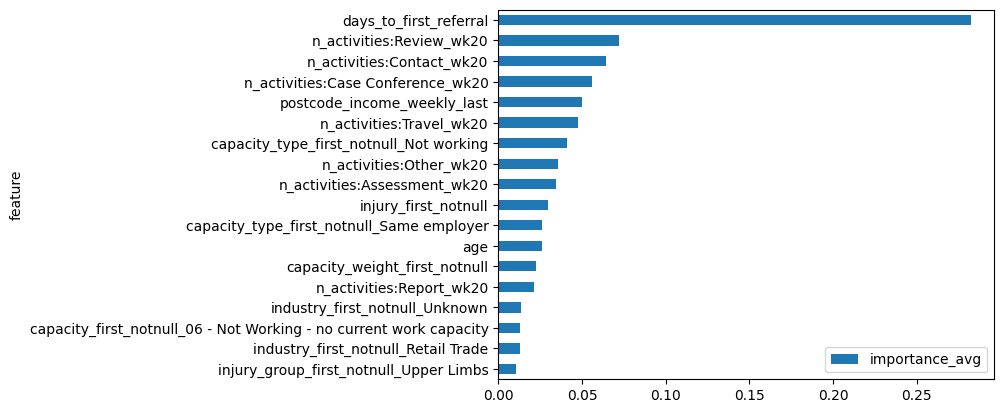

In [39]:
with mlflow.start_run():
    mlflow.set_tag('bus_group', group)
    mlflow.set_tag('outcome', outcome_type)
    mlflow.set_tag('model', model_selected)
    mlflow.set_tag('milestone', milestone)
    mlflow.set_tag('zero_effort', zero_effort)
    mlflow.set_tag('travel_excluded', travel_excluded)
    mlflow.set_tag('reporting_excluded', reporting_excluded)
    mlflow.set_tag('by_type', by_type)
    mlflow.set_tag('effort_type', effort_type)
    mlflow.set_tag('use_effort', use_effort)
    mlflow.log_param('n_splits', n_splits)
    mlflow.log_param('min_upfront_score', min_upfront_score)
    mlflow.log_param('max_upfront_score', max_upfront_score)
    mlflow.log_param('min_claim_total_cost', min_claim_total_cost)
    mlflow.log_param('min_hourly_pctg', min_hourly_pctg)
    mlflow.log_param('n_months', n_months)
    mlflow.set_tag('inc_non_billable', True)
    
    scores=[]
    prob_vs_actual_list=[]
    feature_importances=[]
    fold=0
    for train, test in skf.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        y_pred = model.predict(X.iloc[test])
        y_prob = model.predict_proba(X.iloc[test])
        f1 = f1_score(y.iloc[test], y_pred, average='binary')
        recall = recall_score(y.iloc[test], y_pred)
        precision = precision_score(y.iloc[test], y_pred)
        auc = roc_auc_score(y.iloc[test], y_prob[:, 1])

        scores.append({'precision': precision, 'recall': recall, 'f1':f1, 'auc':auc})

        prob_vs_actual = pd.concat([pd.DataFrame(y_prob[:,1], columns=['prob'], index=test), y.iloc[test]], axis=1)
        prob_vs_actual_list.append(prob_vs_actual)

        #mlflow.log_metric('auc_i', auc, step=fold)

        feature_importances.append(model.feature_importances_)

        fold += 1

    scores_df=pd.DataFrame(scores)

    print(f'Size of entire dataset: {len(X)}')
    print('\n')
    print(scores_df)
    print('\n')
    print(scores_df.mean())

    mlflow.log_metrics({
        'auc_avg':scores_df['auc'].mean(),
        'auc_std':scores_df['auc'].std(),
        'f1_avg':scores_df['f1'].mean(),
        'f1_std':scores_df['f1'].std(),
        'precision_avg':scores_df['precision'].mean(),
        'precision_std':scores_df['precision'].std(),
        'recall_avg':scores_df['recall'].mean(),
        'recall_std':scores_df['recall'].std(),
        })

    # Feature importance
    if False:
        feat_imp = pd.concat([pd.DataFrame(model.feature_importances_, columns=['importance']),pd.DataFrame(X.columns, columns=['Feature'])], axis=1)
        feat_imp = feat_imp.sort_values('importance', ascending=False)
        feat_imp.to_csv(f'output/feature_importance.csv')

        feat_imp = feat_imp.sort_values('importance', ascending=True)
        feat_imp = feat_imp[feat_imp['importance']>0.01]
        fig = feat_imp.plot.barh(x='Feature', y='importance')
        fig.figure.savefig("output/feature_importance.png", bbox_inches='tight')

    if True:
        feature_importance_df = pd.DataFrame(feature_importances, columns=X.columns)
        feat_imp_summ = pd.concat([pd.DataFrame(feature_importance_df.mean(),  columns=['importance_avg']), pd.DataFrame(feature_importance_df.std(),  columns=['importance_std'])], axis=1)
        feat_imp_summ['feature'] = feat_imp_summ.index
        feat_imp_summ.sort_values('importance_avg', ascending=False)
        feat_imp_summ.reset_index(drop=True, inplace=True)
        feat_imp_summ.to_csv(f'output/feature_importance.csv')

        feat_imp_summ = feat_imp_summ.sort_values('importance_avg', ascending=True)
        feat_imp_summ = feat_imp_summ[feat_imp_summ['importance_avg']>0.01]
        fig = feat_imp_summ.plot.barh(x='feature', y='importance_avg')
        fig.figure.savefig("output/feature_importance.png", bbox_inches='tight')

    # Prob vs actual
    prob_vs_actual_all = pd.concat(prob_vs_actual_list)
    prob_vs_actual_all = prob_vs_actual_all.merge(data[['ClaimNo']], left_index=True, right_index=True)
    prob_vs_actual_all.to_csv(f'output/prob_vs_actual.csv')

    mlflow.log_artifact('output')
    #mlflow.log_artifact('output', 'C:/Users/wils_ymarom/Documents/Repos/arriba_sandbox/upfront_risk/artifacts')
    mlflow.log_artifact('encoders')
    
    signature = infer_signature(X, model.predict(X)) # -- sz
    mlflow.sklearn.log_model(model, 'models', input_example=X.iloc[:5], signature=signature) # -- sz
    # mlflow.sklearn.log_model(model, 'models') # -- sz
    mlflow.end_run()

## below 2 blocks seem to be repetitive, comment out --- sz

In [40]:
# prob_vs_actual = prob_vs_actual.merge(data[['ClaimNo']], left_index=True, right_index=True)
# #prob_vs_actual_all.to_csv(f'output/prob_vs_actual.csv')

In [41]:
# prob_vs_actual_all = pd.concat(prob_vs_actual_list)
# prob_vs_actual_all = prob_vs_actual_all.merge(data[['ClaimNo']], left_index=True, right_index=True)
# prob_vs_actual_all.to_csv(f'output/prob_vs_actual.csv')

# Store output for unit testing

In [42]:
# Generate probs for the entire set
if False:
    training_probs = pd.DataFrame(model.predict_proba(X)[:,1], columns=['prob'])
    training_probs = training_probs.merge(data[['ClaimNo']], left_index=True, right_index=True)
    training_probs.to_csv('unit_test_data/LC_Outcome.csv', index=False)
    training_probs.head(5)

# End

In [43]:
## need to head to AML to view Job --> Experiments to view the experiment details
import mlflow
print("Tracking URI:", mlflow.get_tracking_uri())


Tracking URI: azureml://35239ab7-0be2-40d7-96e6-d38aa06a8005.workspace.australiaeast.api.azureml.ms/mlflow/v1.0/subscriptions/24fceea3-b944-4568-9028-d77c36beaab5/resourceGroups/rg-machinelearning-prod-ae-001/providers/Microsoft.MachineLearningServices/workspaces/arriba-mlworkspace-prod-ae-001
